## Generación de bases de datos de EEG contaminadas con EOG artificiales

Este script tiene como objetivo generar 10 bases de datos de señales de EEG contaminadas con EOG, variando el nivel de ruido aplicado para generar diferentes valores de SNR.

Para generar cada base de datos, se utiliza una señal EEG limpia y una señal EOG, ambas en forma de matrices numpy. A partir de estas señales, se aplica una ecuación que permite calcular el valor de lambda necesario para obtener un SNR deseado. Este valor de lambda se utiliza para contaminar la señal EEG limpia con el ruido de la señal EOG.

El nivel de ruido a aplicar se determina a partir del valor de SNR deseado. El SNR es una medida de la relación señal-ruido, que se expresa en decibelios (dB) y se calcula como la relación entre la potencia de la señal y la potencia del ruido. Para obtener un SNR determinado, se utiliza la siguiente fórmula:

SNR = 10 * log10(P_signal / P_noise)

Donde P_signal es la potencia de la señal y P_noise es la potencia del ruido. A partir de esta fórmula, se puede despejar la potencia del ruido:

P_noise = P_signal / (10**(SNR/10))

En este script, se utiliza la raíz cuadrada de la media del cuadrado (RMS) de la señal para calcular la potencia de la señal y del ruido. A partir de estos valores, se calcula el valor de lambda necesario para contaminar la señal EEG limpia con el ruido de la señal EOG.

Para cada base de datos generada, se guarda la señal contaminada en un archivo numpy con extensión ".npy". El nombre del archivo incluye el valor de SNR utilizado para generar la señal contaminada.

## Introduccion

El objetivo de este algoritmo es crear un proceso de contaminación de datos que permita la generación
de datos contaminados artificiales para su posterior consideración en el análisis de EEG limpios.
Para ello, se aplicará una técnica de contaminación que consiste en una combinacion lineal entre los datos EEG limpios y los datos EOG con un valor lambda que determina el alcance de esta contaminacion.

La generación de datos contaminados artificiales es importante ya que permite simular diferentes escenarios de contaminación y validar la efectividad de los métodos de limpieza y análisis de datos de EEG. Además, estos datos seran utilizados para entrenar y evaluar redes neuronales para la deteccion y eliminacion de artefactos EOG en señales EEG.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Cargar datos
El primer paso es cargar los datos de EEG limpios y EOG, las señales se consideran limpias. Es importante considerar un analisis exploratorio de las bases de datos para entender el como se van a relacionar la una con la otra

Forma de la matriz EEG: (4514, 512)
Forma de la matriz EMG: (5598, 512)
Forma de la matriz EEG: (5598, 512)
Forma de la matriz EMG: (5598, 512)


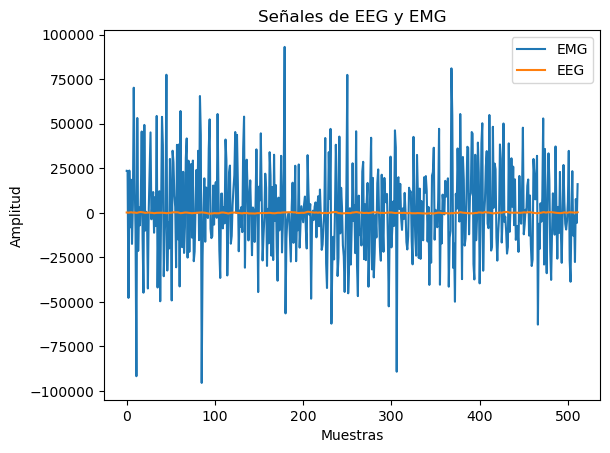

In [32]:
EEG_clean = np.load('data/EEG_all_epochs.npy')
EMG = np.load('data/EMG_all_epochs.npy')

x = EEG_clean.copy()
n = EMG.copy()

print('Forma de la matriz EEG:', x.shape)
print('Forma de la matriz EMG:', n.shape)
indice_signal = 1

# Upsampling del EEG a 512 Hz desde 256 Hz
x_upsampled = np.zeros((x.shape[0], 512))
for i in range(x.shape[0]):
    x_upsampled[i] = np.interp(np.linspace(0, 1, 512), np.linspace(0, 1, x.shape[1]), x[i])

# Reutilización aleatoria de señales EEG
random_indices = np.random.choice(x_upsampled.shape[0], n.shape[0])
x_selected = x_upsampled[random_indices]

x = x_selected.copy()

print('Forma de la matriz EEG:', x.shape)
print('Forma de la matriz EMG:', n.shape)

plt.plot(n[indice_signal], label='EMG')
plt.plot(x[indice_signal], label='EEG')
plt.title('Señales de EEG y EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

## Determinar nivel de contaminacion y generar bases de datos
Ahora para el proceso de contaminacion de los datos es importante calcular el RMS tanto de las señales EEG y EOG, con esta informacion podremos definir el ratio que se necesite entre la señal EEG y el ruido EOG.

Este SNR (Signal to Noise Ratio) se vera representado en un valor lambda.

In [33]:
SNR_values = np.arange(-7, 3)

# calculo de rms de la señal limpia
rms_sample_x = np.sqrt(np.mean(x**2, axis=1))
rms_general_x = np.mean(rms_sample_x)

# calculo de rms del ruido
rms_sample_n = np.sqrt(np.mean(n**2, axis=1))
rms_general_n = np.mean(rms_sample_n)

for SNR in SNR_values:
    lambd = np.sqrt(rms_general_x / rms_general_n) / (10 ** (SNR / 20))
    y = np.empty_like(x)
    for i in range(x.shape[0]):
        y[i, :] = x[i, :] + lambd * n[i % n.shape[0], :]
    
    np.save(f"data/EEG_contaminated_with_EMG/EEG_contaminated_with_EMG_{SNR}db.npy", y)



## Evaluar base de datos generada
Definido un SNR vamos a estar aplicando la ecuacion $y=x+\lambda \cdot n$ para cada valor en la base de datos. Dado que hay menos muestras de EOG que de EEG, las señales de EOG se van a repetir a medida que se procesan las muestras de EEG. Esto se logra utilizando un ciclo for para recorrer todas las filas de la matriz EEG. Para cada fila de la matriz EEG, se selecciona una fila correspondiente de la matriz EOG para generar la señal contaminante $n$

De paso, se dejara definidio un indice de correlacion entre los datos como una forma de validacion de la contaminacion

In [34]:
corr = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    corr[i] = np.corrcoef(x[i], y[i])[0, 1]

print('Coeficiente de correlación medio:', np.mean(corr))

Coeficiente de correlación medio: 0.5192689272497237


En el siguiente grafico se puede observar como la contaminacion afecto exitosamente la señal EEG y esta puede ser usada como forma de datos contaminados artificialmente

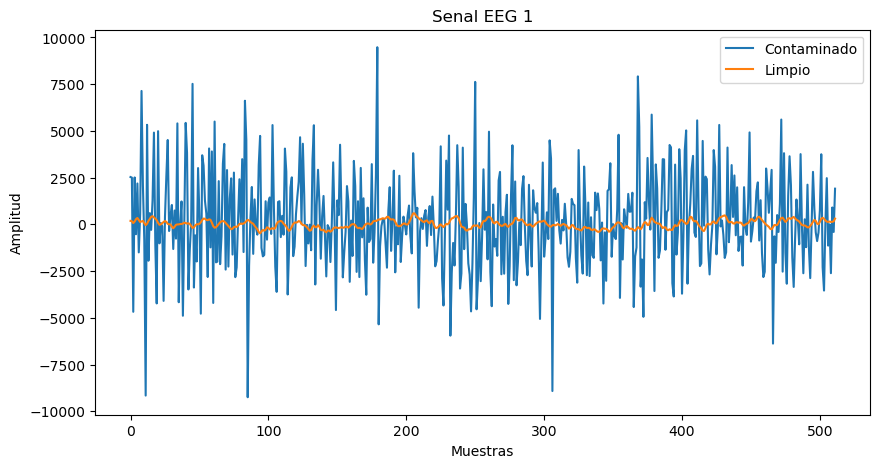

In [36]:
senal_x = x[indice_signal]
senal_y = y[indice_signal]

# Graficar la señal EEG limpia y contaminada
plt.figure(figsize=(10,5))
#plt.plot(n[indice_signal], label='EMG')
plt.plot(senal_y, label='Contaminado')
plt.plot(senal_x, label='Limpio')
plt.legend()
plt.title(f'Senal EEG {indice_signal}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()